In [1]:
import os
from joblib import dump
from pathlib import Path

import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import time

from yellowbrick.model_selection import RFECV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Set up directory
os.chdir("/home/siti/Downloads/New Modelling")

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('AE_Synthetic_Data_Final_V02.csv')

In [3]:
print(df["LOS_Category"].value_counts())

Short stay    11942983
Long stay       779233
Name: LOS_Category, dtype: int64


In [4]:
results_folder = Path("RandomForest_folder/Version 2/Model 1")
results_folder.mkdir(parents=True, exist_ok=True) 

In [5]:
# Convert object types to category
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [6]:
data = df.copy()
# Define the features and target
feature_cols = data.columns[data.columns != 'LOS_Category']
X = data[feature_cols]
y = data['LOS_Category']


# Step 1: Map the Outcome Variable

In [7]:
y = y.map({'Short stay': 1, 'Long stay': 0})

In [8]:
print(y.value_counts())

1    11942983
0      779233
Name: LOS_Category, dtype: int64


# Step 2: Split Data

In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y) 
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

**Overall Proportions:**

- **Test set**: 15% of the original dataset
- **Validation set**: 0.1765 * 0.85 = 0.15 or 15% of the original dataset
- **Training set**: 1−0.15−0.15 = 0.7 or 70% of the original dataset

So, by using this two-step splitting, we've achieved a 70-15-15 split for the training, validation, and test datasets, respectively.

# Step 3: One-Hot Encoding 

In [10]:
# Your nominal columns
nominal_columns = ['Sex', 'AE_Arrival_Mode', 'ICD10_Chapter_Code', 'TFC']

# One-hot encoding
X_train = pd.get_dummies(X_train, columns=nominal_columns, drop_first=True)
X_val = pd.get_dummies(X_val, columns=nominal_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=nominal_columns, drop_first=True)

# Get all columns in X_train after one-hot encoding
all_columns = X_train.columns

# Ensure X_val has the same columns as X_train
for col in all_columns:
    if col not in X_val.columns:
        X_val[col] = 0

# Ensure X_test has the same columns as X_train
for col in all_columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Reorder columns in X_val and X_test to match X_train's order
X_val = X_val[all_columns]
X_test = X_test[all_columns]


# Step 4: Ordinal Encoding

In [11]:
orders = {
    'IMD_Category': ['Most deprived 20%', '20% - 40%', '40 - 60%', '60% - 80%', 'Least deprived 20%'],
    'Age_Band': ['01-17', '18-24', '25-44', '45-64', '65-84', '85+'],
    'AE_Arrive_HourOfDay': ['01-04','05-08','09-12','13-16','17-20','21-24'],
    'AE_HRG': ['Nothing', 'Low', 'Medium', 'High']
}

# Loop through each column and its respective order to encode
for col, order in orders.items():
    ordinal_encoder = OrdinalEncoder(categories=[order])
    X_train[col] = ordinal_encoder.fit_transform(X_train[[col]])
    X_val[col] = ordinal_encoder.transform(X_val[[col]])
    X_test[col] = ordinal_encoder.transform(X_test[[col]])

# Step 5: Oversampling with SMOTE

In [12]:
# Load the oversampled data from the CSV file
df_loaded = pd.read_csv('model1_oversampled_data.csv')

# Separate the features and target variable
X_train_resampled = df_loaded.drop('LOS_Category', axis=1)
y_train_resampled = df_loaded['LOS_Category']

In [13]:
X_train_resampled.head()

,IMD_Category,Age_Band,AE_Arrive_HourOfDay,AE_Time_Mins,AE_HRG,AE_Num_Diagnoses,AE_Num_Investigations,AE_Num_Treatments,Sex_Male,AE_Arrival_Mode_Not known,...,ICD10_Chapter_Code_Other,ICD10_Chapter_Code_X,ICD10_Chapter_Code_XI,ICD10_Chapter_Code_XIV,ICD10_Chapter_Code_XIX,ICD10_Chapter_Code_XVIII,TFC_180,TFC_300,TFC_420,TFC_OTHER
0,1.0,4.0,3.0,130,2.0,1,2,5,1,0,...,1,0,0,0,0,0,0,0,0,1
1,1.0,3.0,3.0,300,2.0,2,6,4,0,0,...,0,0,0,1,0,0,0,0,0,1
2,3.0,2.0,1.0,60,2.0,1,4,5,1,1,...,0,1,0,0,0,0,0,1,0,0
3,0.0,5.0,4.0,240,3.0,0,5,3,1,1,...,0,0,0,0,1,0,0,0,0,1
4,4.0,4.0,3.0,130,0.0,1,1,1,0,1,...,0,0,0,0,1,0,0,0,0,1


In [14]:
proportions = y_train_resampled.value_counts(normalize=True)
print(proportions)

counts = y_train_resampled.value_counts(normalize=False)
print(counts)

1    0.5
0    0.5
Name: LOS_Category, dtype: float64
1    8359788
0    8359788
Name: LOS_Category, dtype: int64


In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

# Use only 10% of the data for hyperparameter tuning using stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, subset_index in sss.split(X_train_resampled, y_train_resampled):
    X_train_subset = X_train_resampled.iloc[subset_index]
    y_train_subset = y_train_resampled.iloc[subset_index]
    
# Standardize the subset
scaler = StandardScaler()
X_train_subset_scaled = scaler.fit_transform(X_train_subset)


In [16]:

counts = y_train_subset.value_counts(normalize=False)
print(counts)

1    835979
0    835979
Name: LOS_Category, dtype: int64


# Step 6: Standardize Dataset

In [17]:
# Scale the rest of the data using the subset's statistics
X_train_scaled = scaler.transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 7: RFECV

Perform RFECV on the training set (not including the validation set).

RFECV took 2912.81 seconds.


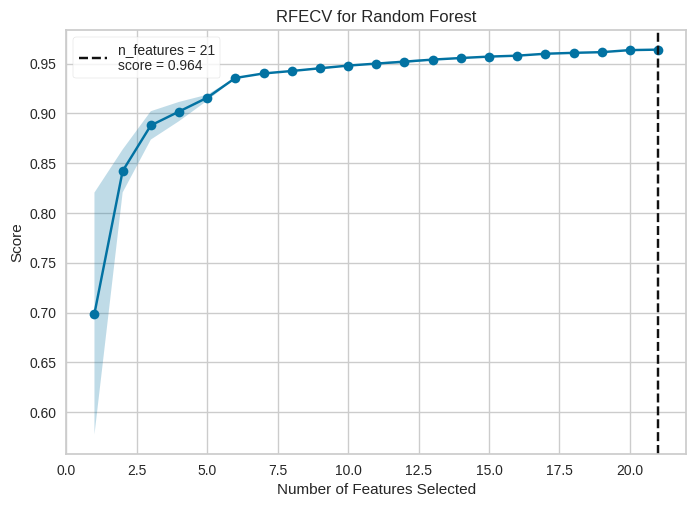

In [18]:
# Number of cores to use
n_cores = 7  # Adjust as necessary

# Record the start time
start_time = time.time()

# Initialize the XGBoost estimator to mimic Random Forest
estimator = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    booster='gbtree',
    n_estimators=100,  # Number of trees
    tree_method='hist',
    max_depth=6,
    n_jobs=n_cores,  # Changed from deprecated nthread to n_jobs
    subsample=0.8,  # Randomly sample 80% of the training data before growing trees
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    random_state=42
)

plt_title = "RFECV for Random Forest"

# Initialize RFECV
visualizer = RFECV(estimator, step=1, cv=5, scoring='roc_auc', n_jobs=n_cores, title = plt_title)

# Assuming X_train_scaled and y_train_resampled are your scaled feature matrix and target array
# Fit the data to the visualizer
visualizer.fit(X_train_subset_scaled, y_train_subset)

# Show the visualizer
visualizer.show(outpath= results_folder / "RFECV.png")

# Record the end time
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"RFECV took {duration:.2f} seconds.")

In [19]:
# Print the features selected by RFECV
feature_names = X_train.columns

# Map the selected features to the original column names
selected_features = [feature for mask, feature in zip(visualizer.support_, feature_names) if mask]

print("Selected Features:", selected_features)

Selected Features: ['IMD_Category', 'Age_Band', 'AE_Arrive_HourOfDay', 'AE_Time_Mins', 'AE_HRG', 'AE_Num_Diagnoses', 'AE_Num_Investigations', 'AE_Num_Treatments', 'Sex_Male', 'AE_Arrival_Mode_Not known', 'AE_Arrival_Mode_Other', 'ICD10_Chapter_Code_Other', 'ICD10_Chapter_Code_X', 'ICD10_Chapter_Code_XI', 'ICD10_Chapter_Code_XIV', 'ICD10_Chapter_Code_XIX', 'ICD10_Chapter_Code_XVIII', 'TFC_180', 'TFC_300', 'TFC_420', 'TFC_OTHER']


# Step 8: Hyperparameter Tuning with Randomized Search CV

After feature selection, use RandomizedSearchCV for hyperparameter tuning on the training set. The cross-validation within RandomizedSearchCV uses multiple train-validation splits of the training data.

Use only 10% percent of the training set to perform hyperparameter tuning due to insuffient CPU and GPU resources. The training set is very high after oversampling.

In [20]:

# Extract columns from the scaled and resampled training set using the list of selected features
selected_feature_indices = [X_train.columns.get_loc(feature) for feature in selected_features]
X_train_selected_scaled = X_train_scaled[:, selected_feature_indices]

# Filter X_train_subset_scaled with the best features
X_train_selected_subset_scaled = X_train_subset_scaled[:, selected_feature_indices]

In [21]:
# Define the hyperparameter grid for Random Forest
param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(1, 10),
    'min_samples_split': uniform(0.1, 0.9),  # Changed upper limit to 0.9
    'min_samples_leaf': uniform(0.1, 0.5),
    'max_features': ['sqrt', 'log2'],  # Removed 'auto'
    'bootstrap': [True, False]
}

# Record the start time
start_time = time.time()

# Initialize the RandomizedSearchCV with RandomForestClassifier
random_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced'), 
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=1,
    n_jobs=7,
    random_state=42,
    scoring='roc_auc'
)

# Execute your RandomizedSearchCV using the selected and scaled features
random_search.fit(X_train_selected_subset_scaled, y_train_subset)

# Save the cv_results_ to a DataFrame and then to a CSV file
cv_results_df = pd.DataFrame(random_search.cv_results_)
cv_results_df.to_csv(results_folder /'cv_results.csv', index=False)

# Print results
print("Best parameters for RF:", random_search.best_params_)
print("Best ROC-AUC score for RF:", random_search.best_score_)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Hyperparameter tuning for RF took {duration:.2f} seconds.")

# Save the model
dump(random_search, results_folder / 'random_search_model.joblib')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for RF: {'bootstrap': False, 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 0.1156566462277793, 'min_samples_split': 0.8580562971354987, 'n_estimators': 143}
Best ROC-AUC score for RF: 0.7694857394031873
Hyperparameter tuning for RF took 3378.57 seconds.


['RandomForest_folder/Version 2/Model 1/random_search_model.joblib']

# Step 9: Train the whole dataset with best hyperparameters


In [22]:
# Extracting selected features for validation, and test sets:

X_val_selected_scaled = X_val_scaled[:, selected_feature_indices]
X_test_selected_scaled = X_test_scaled[:, selected_feature_indices]

In [23]:
# Define the best hyperparameters
best_params = random_search.best_params_

# Record the start time
start_time = time.time()

# Train a RF model using the best hyperparameters on the training set
best_model = RandomForestClassifier(**best_params, n_jobs=7)
best_model.fit(X_train_selected_scaled, y_train_resampled)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Training for RF took {duration:.2f} seconds.")

Training for RF took 120.89 seconds.


# Step 10: Predict and Evaluate on Validation Set

In [24]:
# Record the start time
start_time = time.time()

# Predict & Evaluate on the validation set
y_val_pred = best_model.predict(X_val_selected_scaled.astype(np.float32))
y_val_prob = best_model.predict_proba(X_val_selected_scaled.astype(np.float32))[:, 1]

val_metrics = {
    'Accuracy': accuracy_score(y_val, y_val_pred),
    'ROC-AUC': roc_auc_score(y_val, y_val_prob),
    'F1 Score': f1_score(y_val, y_val_pred),
    'Precision': precision_score(y_val, y_val_pred),
    'Recall': recall_score(y_val, y_val_pred)
}

print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value}")
    
# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Validating for RF took {duration:.2f} seconds.")

Validation Metrics:
Accuracy: 0.6017485648240564
ROC-AUC: 0.7175434651839121
F1 Score: 0.7358292732344869
Precision: 0.9751198825399808
Recall: 0.5908395549148401
Validating for RF took 5.10 seconds.


# Step 11: Final Model Training and Test Evaluation

Finally, we train on the combined train+validation data and test on the test set.

In [25]:
# Record the start time
start_time = time.time()

# Combine the training and validation sets
X_combined = np.concatenate([X_train_selected_scaled, X_val_selected_scaled], axis=0)
y_combined = np.concatenate([y_train_resampled, y_val], axis=0)

# Train the final model on the combined set
final_model = RandomForestClassifier(**best_params, n_jobs=7)
final_model.fit(X_combined, y_combined)

# Record the end time
end_time = time.time()
duration = end_time - start_time

print(f"Training RF took {duration:.2f} seconds.")

Training RF took 134.87 seconds.


In [26]:
dump(final_model, results_folder / 'final_model_RF.joblib')

['RandomForest_folder/Version 2/Model 1/final_model_RF.joblib']

# Step 12: Predict on test set

In [28]:
# Predict & Evaluate on the test set
y_test_pred = final_model.predict(X_test_selected_scaled.astype(np.float32))
y_test_prob = final_model.predict_proba(X_test_selected_scaled.astype(np.float32))[:, 1]

test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'ROC-AUC': roc_auc_score(y_test, y_test_prob),
    'F1 Score': f1_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred)
}

print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))



Test Metrics:
Accuracy: 0.7325314816648876
ROC-AUC: 0.7140452946979396
F1 Score: 0.8395132376212999
Precision: 0.9611352092700117
Recall: 0.7452139275044545
Confusion Matrix:
[[  62902   53983]
 [ 456436 1335012]]


# Step 13: Save the metrics

In [29]:
# Save all metrics in a csv file

# Convert the metrics to a DataFrame
metrics_df = pd.DataFrame(list(test_metrics.items()), columns=['Metric', 'Value'])

# Save to CSV
output_path = results_folder / "Model1_Performance_metrics.csv"
metrics_df.to_csv(output_path, index=False)

print(f"Metrics saved to: {output_path}")

Metrics saved to: RandomForest_folder/Version 2/Model 1/Model1_Performance_metrics.csv


# ROC-AUC Curve

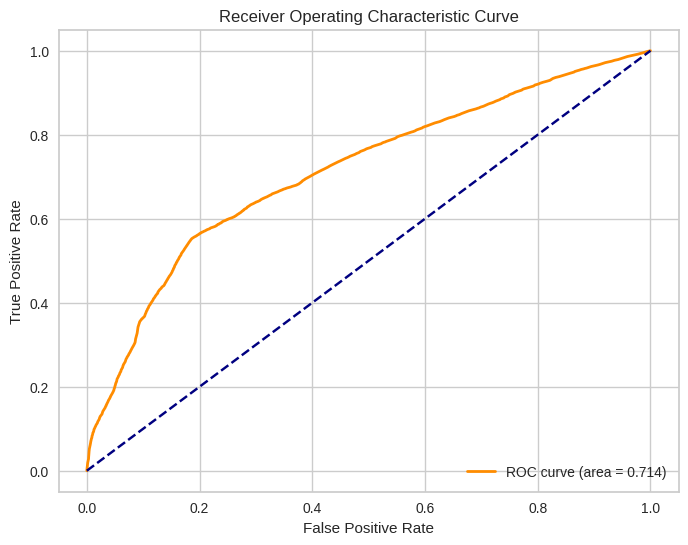

In [30]:
# Plot ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.savefig(results_folder / "roc_auc.png", dpi=300)
plt.show()

# Precision-Recall Curve

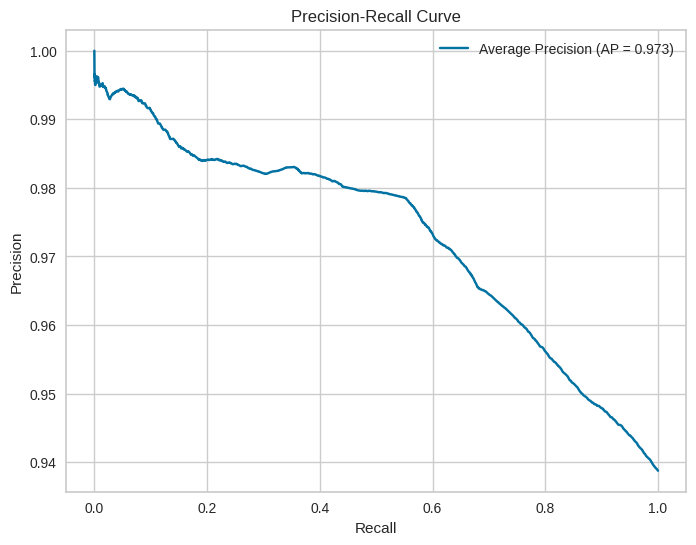

In [31]:
# Plot Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
average_precision = average_precision_score(y_test, y_test_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='Average Precision (AP = %0.3f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.savefig(results_folder / "precision_recall.png", dpi=300)
plt.show()

# Calculate Error

Combined (Training + Validation) Error:

Predict on the combined dataset.
Calculate accuracy on the combined dataset.
Derive the error from the accuracy (i.e., 1 - accuracy).

Validation Error:

Predict on the validation dataset.
Calculate accuracy on the validation dataset.
Derive the error from the accuracy.

Test Error:

Predict on the test dataset.
Calculate accuracy on the test dataset.
Derive the error from the accuracy.

In [32]:
# Predict on training set
y_combined_pred = final_model.predict(X_combined)
combined_accuracy = accuracy_score(y_combined, y_combined_pred)
combined_error = 1 - combined_accuracy

# Predict on validation set
y_val_pred = final_model.predict(X_val_selected_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_error = 1 - val_accuracy

# Predict on test set
y_test_pred = final_model.predict(X_test_selected_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy

print(f"Combined Error: {combined_error:.3f}")
print(f"Validation Error: {val_error:.3f}")
print(f"Test Error: {test_error:.3f}")

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Combined Error', 'Validation Error', 'Test Error'],
    'Value': [combined_error, val_error, test_error]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv(results_folder / 'Model_Metrics.csv', index=False)

Combined Error: 0.316
Validation Error: 0.267
Test Error: 0.267


# Feature Importance

Need to use Scikit-Learn package to get feature importances.

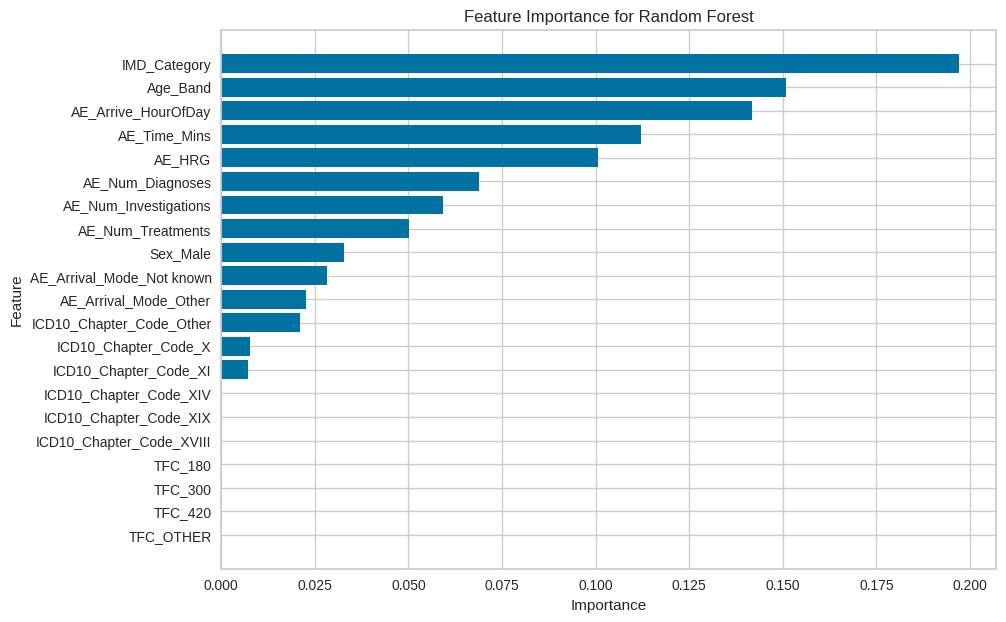

In [33]:

# Retrieve Feature Importance
importances = final_model.feature_importances_

# Match Feature Importance to Feature Names:
feature_names = [X_train.columns[i] for i in selected_feature_indices]

# Sort Features by Importance:
sorted_idx = np.argsort(importances)[::-1]

# Plot

plt.figure(figsize=(10, 7))
plt.barh(feature_names, importances[sorted_idx])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for Random Forest")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.savefig(results_folder / "Feature_Importance.png", dpi=300)
plt.show()

In [34]:
# Create a DataFrame to hold feature names and their corresponding importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame based on the importance scores
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Save the DataFrame to a CSV file
feature_importance_df.to_csv(results_folder / 'Feature_Importance.csv', index=False)